## **Data Transformation - Data Exploration**

Loaded 'casos_covid19.csv' successfully.
Confirmed cases: 14727 rows
Valid dates only: 14727 rows
2024 data: 14067 rows

Saved processed data to 'covid_cases_processed.csv'
Saved plot to 'covid_cases_per_day.png'


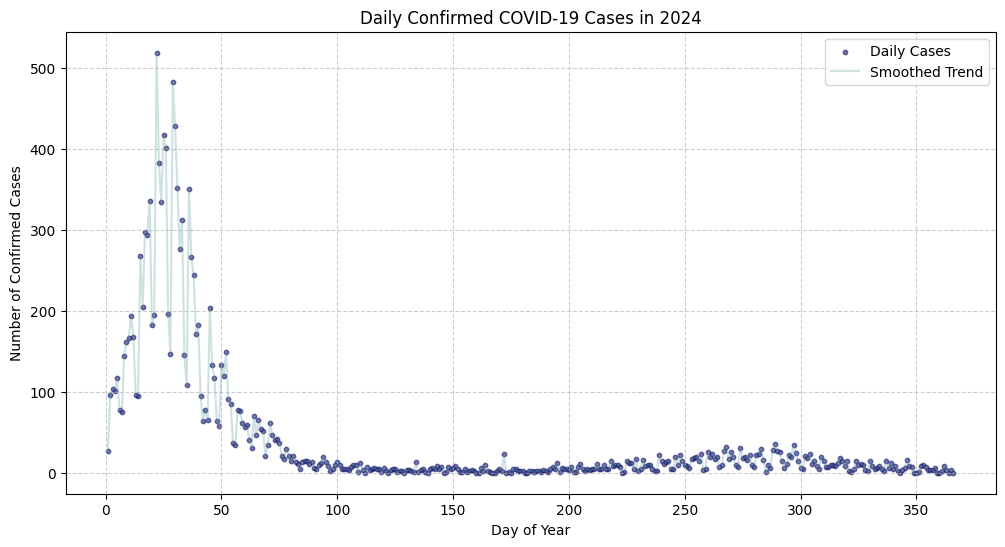

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Load the COVID-19 dataset from local CSV
file_name = "/content/casos_covid19.csv"
try:
    df = pd.read_csv(file_name, sep=';', on_bad_lines='skip')
    print("Loaded 'casos_covid19.csv' successfully.")
except FileNotFoundError:
    print(f"File not found: {file_name}")
except Exception as e:
    print(f"Error loading file: {e}")
    exit()

#Filter and prepare data

#Keep only confirmed cases
df_confirmed = df[df['clasificacion'] == 'confirmado'].copy()
print(f"Confirmed cases: {len(df_confirmed)} rows")

#Convert sample dates to datetime
df_confirmed['date'] = pd.to_datetime(df_confirmed['fecha_toma_muestra'], errors='coerce')

#Remove rows with invalid dates
df_confirmed.dropna(subset=['date'], inplace=True)
print(f"Valid dates only: {len(df_confirmed)} rows")

#Filter for 2024 data
df_2024 = df_confirmed[df_confirmed['date'].dt.year == 2024].copy()
print(f"2024 data: {len(df_2024)} rows")

#Count confirmed cases per day
daily_counts = df_2024.groupby('date').size().reset_index(name='case_count')

#Create time-based features

#Fill in missing days in 2024 with 0 cases
all_days_2024 = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
daily_counts_full = daily_counts.set_index('date').reindex(all_days_2024, fill_value=0).reset_index()
daily_counts_full.rename(columns={'index': 'date'}, inplace=True)

#Add day-of-year and its standardized version
daily_counts_full['day_of_year'] = daily_counts_full['date'].dt.dayofyear
daily_counts_full['day_of_year_std'] = (
    (daily_counts_full['day_of_year'] - daily_counts_full['day_of_year'].mean()) /
    daily_counts_full['day_of_year'].std()
)

#Save cleaned data
processed_file = "covid_cases_processed.csv"
daily_counts_full.to_csv(processed_file, index=False)
print(f"\nSaved processed data to '{processed_file}'")

#Plot daily case counts
plt.figure(figsize=(12, 6))
plt.scatter(
    daily_counts_full['day_of_year'],
    daily_counts_full['case_count'],
    alpha=0.6,
    s=10,
    color='midnightblue',
    label='Daily Cases'
)
plt.plot(
    daily_counts_full['day_of_year'],
    daily_counts_full['case_count'],
    alpha=0.3,
    color='cadetblue',
    label='Smoothed Trend'
)
plt.title('Daily Confirmed COVID-19 Cases in 2024')
plt.xlabel('Day of Year')
plt.ylabel('Number of Confirmed Cases')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('covid_cases_per_day.png')
print("Saved plot to 'covid_cases_per_day.png'")
plt.show()

## **Model 1: Simple Linear Regression**

In [2]:
import pymc as pm
import arviz as az

#Default credible interval to 89%
az.rcParams["stats.ci_prob"] = 0.89

#Load processed dataset
file_name = "covid_cases_processed.csv"
df = pd.read_csv(file_name)

#Prepare variables for modeling
y_data = df['case_count'].values # target variable
x_data_std = df['day_of_year_std'].values # standardized predictor
x_data_orig = df['day_of_year'].values # original predictor (for plotting)

print("--- Data Loaded ---")

--- Data Loaded ---


In [3]:
print(f"Modeling 'case_count' vs 'day_of_year' for {len(df)} days.")

#MODEL 1: Simple Linear Regression (Session 7 PCW)
print("\n--- Starting Model 1: Simple Linear Regression (Normal) ---")

with pm.Model() as model_1_linear:
    #Prior for intercept: around the mean of y, with wide uncertainty
    a = pm.Normal("a", mu=y_data.mean(), sigma=y_data.std() * 2)

    #Prior for slope: centered at 0 with moderate spread
    b = pm.Normal("b", mu=0, sigma=10)

    #Prior for noise: positive-only, based on standard deviation of y
    sigma = pm.HalfNormal("sigma", sigma=y_data.std())

    #Linear prediction for each day
    mu = pm.Deterministic("mu", a + b * x_data_std)

    #Likelihood: model daily case counts as Normal around mu
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data)

    #Sample from the posterior
    #idata_kwargs ensures compatibility with model comparison later
    trace_1_linear = pm.sample(
        2000,
        tune=2000,
        chains=4,
        idata_kwargs={"log_likelihood": True}
    )

print("\n--- Model 1 Sampling Complete ---")


Modeling 'case_count' vs 'day_of_year' for 366 days.

--- Starting Model 1: Simple Linear Regression (Normal) ---


Output()


--- Model 1 Sampling Complete ---



--- Model 1: Summary ---
        mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a      38.45  3.60     32.96      44.39       0.03     0.04  11097.09   
b     -37.83  3.49    -43.34     -32.18       0.03     0.04  11772.28   
sigma  69.34  2.60     65.16      73.30       0.02     0.03  11896.23   

       ess_tail  r_hat  
a       6054.33    1.0  
b       5797.57    1.0  
sigma   6277.45    1.0  
Saved 'model_1_linear_fit.png'


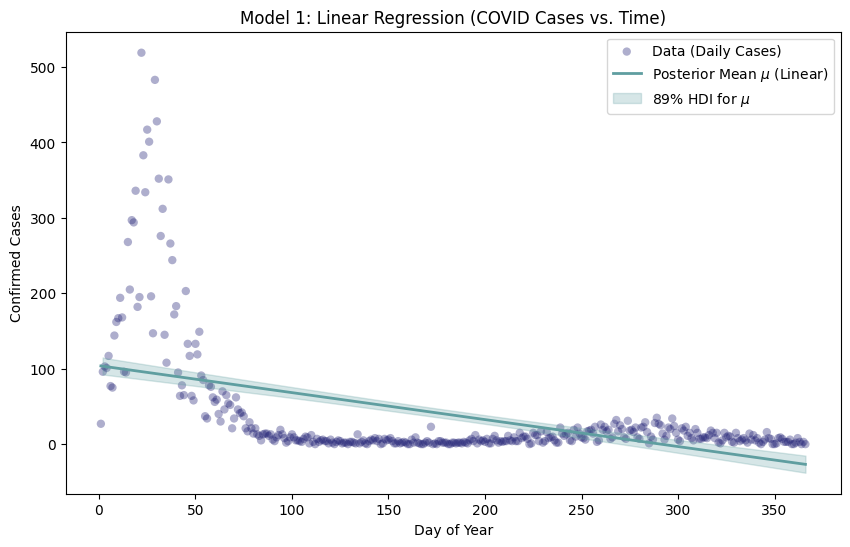

In [4]:
#Model 1: Check Results
print("\n--- Model 1: Summary ---")
varnames = ["a", "b", "sigma"]
summary_1 = az.summary(trace_1_linear, var_names=varnames, round_to=2)
print(summary_1)

#Model 1: Visualization
mu_pred_1 = trace_1_linear.posterior["mu"]

#Generate a standardized sequence for smooth line plotting
x_seq_std  = np.linspace(x_data_std.min(),  x_data_std.max(),  100)
x_seq_orig = np.linspace(x_data_orig.min(), x_data_orig.max(), 100)

#Compute posterior mean trend line
mu_line_1 = (trace_1_linear.posterior["a"].mean(dim=["chain", "draw"]).item()
    + trace_1_linear.posterior["b"].mean(dim=["chain", "draw"]).item() * x_seq_std)

#Plot the data and fitted line
plt.figure(figsize=(10, 6))
plt.scatter(x_data_orig, y_data, alpha=0.35, label='Data (Daily Cases)', color="midnightblue", edgecolors='none')
plt.plot(x_seq_orig, mu_line_1, color="cadetblue", linewidth=2, label=r'Posterior Mean $\mu$ (Linear)')
az.plot_hdi(x_data_orig, mu_pred_1, hdi_prob=0.89, color="lightslategray", fill_kwargs={'alpha': 0.25, 'color': "cadetblue", 'label': r'89% HDI for $\mu$'})

plt.title('Model 1: Linear Regression (COVID Cases vs. Time)')
plt.xlabel('Day of Year')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.savefig('model_1_linear_fit.png')
print("Saved 'model_1_linear_fit.png'")
plt.show()


## **Model 2: Polynomial Regression**

In [5]:
#MODEL 2: CUBIC (3rd-degree) REGRESSION (from Session 9)

print("\n--- Starting Model 2: Cubic (3rd-degree) Regression ---")

#Create new features: x squared and x cubed
x_data_std_2 = x_data_std**2
x_data_std_3 = x_data_std**3

with pm.Model() as model_2_cubic:
    #Priors
    #Set a prior for the intercept. Centered at the mean of the data
    a = pm.Normal("a", mu=y_data.mean(), sigma=y_data.std() * 2)

    #Set priors for the slope terms: linear (b1), quadratic (b2), and cubic (b3)
    b1 = pm.Normal("b1", mu=0, sigma=10)
    b2 = pm.Normal("b2", mu=0, sigma=10)
    b3 = pm.Normal("b3", mu=0, sigma=10) #Helps the curve bend a second time

    #Prior for the standard deviation (how much the data spreads around the mean line)
    sigma = pm.HalfNormal("sigma", sigma=y_data.std())

    #Regression Mean
    # This is the formula for our curve: a + b1*x + b2*x^2 + b3*x^3
    mu = pm.Deterministic("mu", a + b1 * x_data_std + b2 * x_data_std_2 + b3 * x_data_std_3)

    #Likelihood
    # We assume the observed data follows a normal distribution around mu
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data)

    #Sampling
    #Draw samples from the posterior to estimate the parameters
    trace_2_cubic = pm.sample(
        2000,
        tune=2000,
        chains=4,
        idata_kwargs={"log_likelihood": True}  #Needed for model comparison later
    )

print("\n--- Model 2 Sampling Complete ---")


--- Starting Model 2: Cubic (3rd-degree) Regression ---


Output()


--- Model 2 Sampling Complete ---


        mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a      -0.96  4.01     -7.32       5.59       0.05     0.04   5970.18   
b1      3.49  5.51     -5.39      12.28       0.08     0.07   4495.68   
b2     39.52  2.93     34.65      44.09       0.04     0.03   5839.13   
b3    -25.95  2.91    -30.35     -21.05       0.04     0.04   4802.10   
sigma  52.41  1.99     49.20      55.50       0.02     0.02   6810.82   

       ess_tail  r_hat  
a       5552.90    1.0  
b1      4520.05    1.0  
b2      5377.41    1.0  
b3      4476.14    1.0  
sigma   5350.46    1.0  
Saved 'model_2_cubic_fit.png'


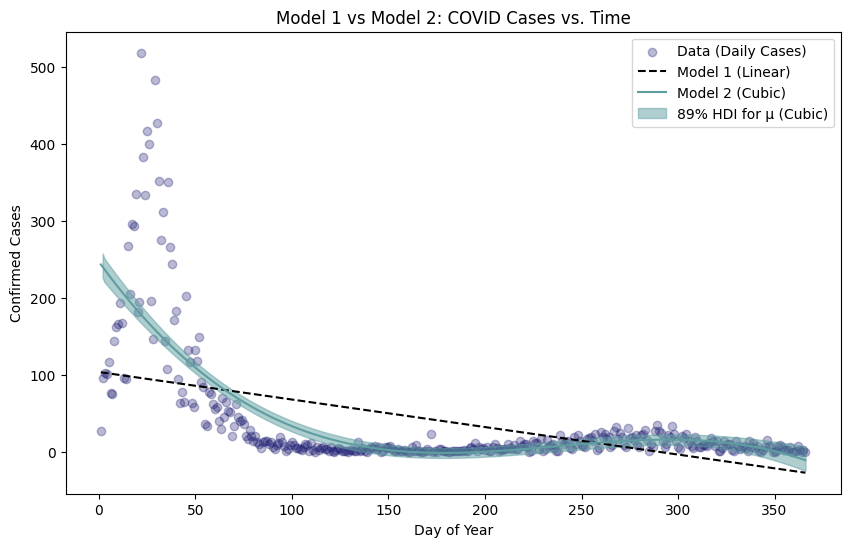

In [6]:
#Show a summary of the main parameters in Model 2
varnames = ["a", "b1", "b2", "b3", "sigma"]
print(az.summary(trace_2_cubic, var_names=varnames, round_to=2))

#Visualization: Comparing Model 1 and Model 2

#Prepare x values for prediction
#Create a sequence of standardized and original x values to use in our line plots
x_seq_std  = np.linspace(x_data_std.min(),  x_data_std.max(),  100)
x_seq_orig = np.linspace(x_data_orig.min(), x_data_orig.max(), 100)

#Model 1: Linear prediction line
# Use the mean posterior values for the intercept and slope to build the line
mu_line_1 = (
    trace_1_linear.posterior["a"].mean(dim=["chain", "draw"]).item()
    + trace_1_linear.posterior["b"].mean(dim=["chain", "draw"]).item() * x_seq_std
)

#Model 2: Cubic prediction line
#Pull out the posterior for mu (trend) and build a prediction line using mean parameters
mu_pred_2 = trace_2_cubic.posterior["mu"]
x_seq_std_2 = x_seq_std**2
x_seq_std_3 = x_seq_std**3

mu_line_2_cubic = (
    trace_2_cubic.posterior["a"].mean(dim=["chain", "draw"]).item()
    + trace_2_cubic.posterior["b1"].mean(dim=["chain", "draw"]).item() * x_seq_std
    + trace_2_cubic.posterior["b2"].mean(dim=["chain", "draw"]).item() * x_seq_std_2
    + trace_2_cubic.posterior["b3"].mean(dim=["chain", "draw"]).item() * x_seq_std_3
)

#Plot both models over the data
plt.figure(figsize=(10, 6))

#Plot original data
plt.scatter(x_data_orig, y_data, alpha=0.3, color="midnightblue", label='Data (Daily Cases)')

#Add Model 1 line (dashed)
plt.plot(x_seq_orig, mu_line_1, color='k', linestyle='--', label='Model 1 (Linear)')

#Add Model 2 line (solid)
plt.plot(x_seq_orig, mu_line_2_cubic, color='cadetblue', label='Model 2 (Cubic)')

#Add HDI (uncertainty band) around Model 2
az.plot_hdi(
    x_data_orig, mu_pred_2,
    color='cadetblue',
    hdi_prob=0.89,
    fill_kwargs={'alpha': 0.5, 'label': '89% HDI for μ (Cubic)'}
)

#Final plot formatting
plt.title('Model 1 vs Model 2: COVID Cases vs. Time')
plt.xlabel('Day of Year')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.savefig('model_2_cubic_fit.png')
print("Saved 'model_2_cubic_fit.png'")
plt.show()

In [7]:
#MODEL COMPARISON (PSIS-LOO)
print("\n--- Starting Model Comparison (PSIS-LOO) ---")

models_dict = {
    "Model 1 (Linear)": trace_1_linear,
    "Model 2 (Cubic)": trace_2_cubic,
}

compare_df = az.compare(models_dict, ic="loo")
print("\n--- Model Comparison Results ---")
print(compare_df)


--- Starting Model Comparison (PSIS-LOO) ---

--- Model Comparison Results ---
                  rank     elpd_loo      p_loo  elpd_diff    weight  \
Model 2 (Cubic)      0 -1975.941850  15.203707   0.000000  0.939924   
Model 1 (Linear)     1 -2074.961866   9.214396  99.020016  0.060076   

                         se        dse  warning scale  
Model 2 (Cubic)   42.083579   0.000000    False   log  
Model 1 (Linear)  36.449112  15.114375    False   log  


Output()


--- Generating Residuals vs. Time Plot (Model 2) ---


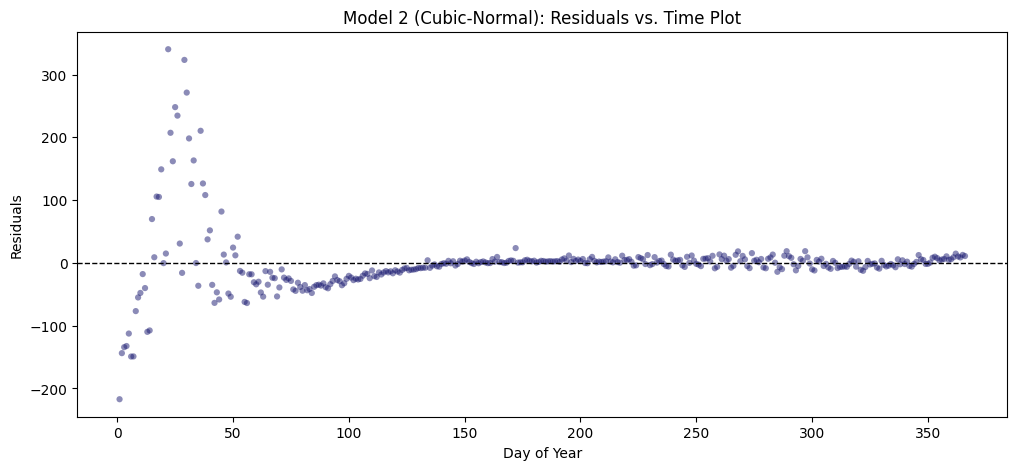

In [8]:
# This block is adapted from in-class material (Session 9). It generates fitted values and residuals for Model 2 (Cubic with Normal likelihood), and plots the residuals over time.

#Posterior Predictive Sampling
#This generates samples from the posterior predictive distribution
#It gives us simulated case counts using the model's uncertainty
with model_2_cubic:
    ppc_2_cubic = pm.sample_posterior_predictive(trace_2_cubic, var_names=["y_obs"])

#Compute Fitted Values and Residuals

#Get predicted values (posterior predictive draws for each day)
y_pp = ppc_2_cubic.posterior_predictive["y_obs"]

#Take the average over all draws and chains to get a single fitted value per day
y_hat_mean = np.asarray(y_pp.mean(dim=("chain", "draw")).values, dtype=float)

#The fitted value is the model’s average prediction for each day
fitted = y_hat_mean

#Residual = Actual - Predicted
#This tells us how far off the model was for each day
resid = y_data - fitted

#Plot Residuals Over Time
# This helps us check for patterns the model missed
print("\n--- Generating Residuals vs. Time Plot (Model 2) ---")
plt.figure(figsize=(12, 5))
plt.scatter(x_data_orig, resid, s=20, color="midnightblue", alpha=0.5, edgecolors="none")
plt.axhline(0, color="black", lw=1, linestyle='--')  # Baseline at 0 residual
plt.title("Model 2 (Cubic-Normal): Residuals vs. Time Plot")
plt.xlabel("Day of Year")
plt.ylabel("Residuals")
plt.savefig("model_2_resid_vs_time.png")
plt.show()

## **Model 3: The Right Tool**

In [9]:
#MODEL 3: CUBIC NEGATIVE BINOMIAL (The "Correct" Model)
print("\n--- Starting Model 3: Cubic Negative Binomial Regression ---")

# We'll reuse x^2 and x^3 to let the model bend in two places (same cubic shape as Model 2)
x_data_std_2 = x_data_std**2
x_data_std_3 = x_data_std**3

with pm.Model() as model_3_neg_bin:
    #Priors (now on log scale)
    #Intercept (a) is now on log scale, so it's centered near 0
    a = pm.Normal("a", mu=0, sigma=5)
    b1 = pm.Normal("b1", mu=0, sigma=1)
    b2 = pm.Normal("b2", mu=0, sigma=1)
    b3 = pm.Normal("b3", mu=0, sigma=1)

    #Overdispersion parameter (alpha): controls extra variance
    #Exponential is a common prior for positive-only parameters
    alpha = pm.Exponential("alpha", 0.5)

    #Mean Function (Still Cubic)
    #We model log(mu) instead of mu directly to make sure it's always positive
    log_mu = pm.Deterministic("log_mu", a + b1 * x_data_std + b2 * x_data_std_2 + b3 * x_data_std_3)

    #Convert log(mu) back to mu
    mu = pm.Deterministic("mu", pm.math.exp(log_mu))

    #Likelihood
    #Negative Binomial is more flexible than Normal, good for noisy count data
    y_obs = pm.NegativeBinomial("y_obs", mu=mu, alpha=alpha, observed=y_data)

    #Sampling
    # We sample from the posterior and store log_likelihood info for model comparison
    trace_3_neg_bin = pm.sample(2000, tune=2000, chains=4, idata_kwargs={"log_likelihood": True})

print("\n--- Model 3 Sampling Complete ---")

varnames = ["a", "b1", "b2", "b3", "alpha"]
print(az.summary(trace_3_neg_bin, var_names=varnames, round_to=2))


--- Starting Model 3: Cubic Negative Binomial Regression ---


Output()


--- Model 3 Sampling Complete ---
       mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a      1.71  0.07      1.59       1.82        0.0      0.0   4951.84   
b1     0.78  0.11      0.60       0.95        0.0      0.0   4300.36   
b2     0.96  0.06      0.86       1.05        0.0      0.0   5076.36   
b3    -0.91  0.06     -1.01      -0.81        0.0      0.0   4496.77   
alpha  1.75  0.15      1.51       1.98        0.0      0.0   6375.32   

       ess_tail  r_hat  
a       5005.51    1.0  
b1      4441.23    1.0  
b2      4853.93    1.0  
b3      4551.17    1.0  
alpha   4563.64    1.0  


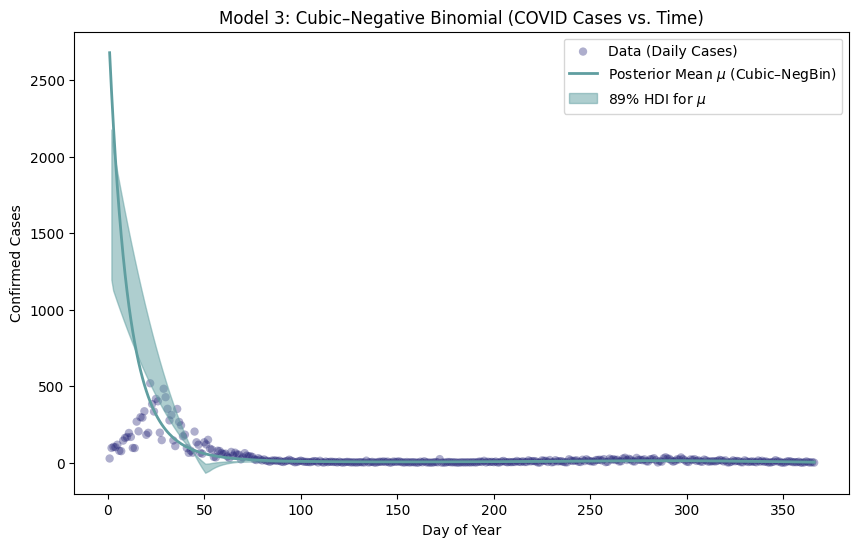

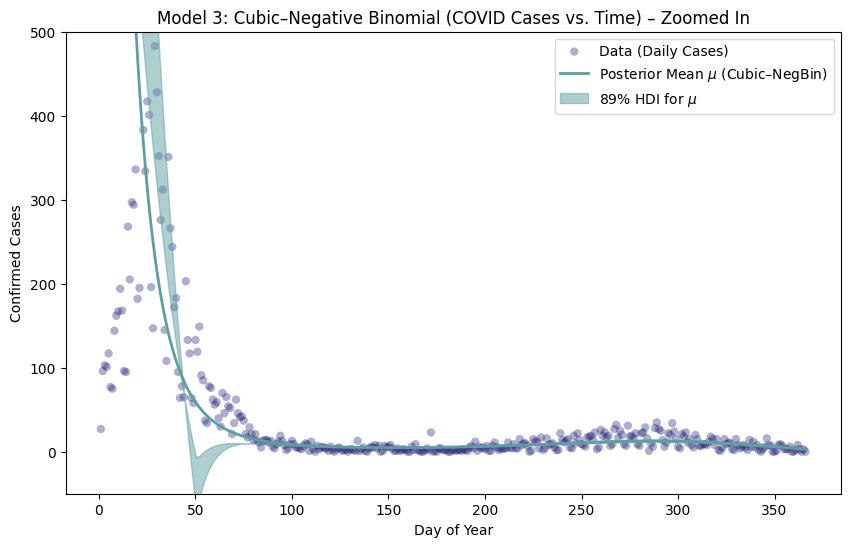

In [10]:
#Model 3: Mean Trend Line + 89% HDI Band
#This plot shows the predicted trend of daily COVID-19 cases using our best model (Model 3)
#We compute the mean of the posterior samples for each day to get the expected number of cases (mu)
#We also add the 89% HDI band to show uncertainty around the tren

mu_pred_3 = trace_3_neg_bin.posterior["mu"] #Posterior samples of mu(t)
mu_line_3 = mu_pred_3.mean(dim=("chain", "draw")).values #Average mu(t) across all samples

#Full-scale plot (includes the large January spikes
plt.figure(figsize=(10, 6))
plt.scatter(x_data_orig, y_data, alpha=0.35, color="midnightblue", edgecolors="none", label="Data (Daily Cases)") #Show actual data points
plt.plot(x_data_orig, mu_line_3, color="cadetblue", linewidth=2, label=r"Posterior Mean $\mu$ (Cubic–NegBin)") #Show model’s fitted mean line
az.plot_hdi(x_data_orig, mu_pred_3, color="cadetblue", hdi_prob=0.89, fill_kwargs={"alpha": 0.5, "label": r"89% HDI for $\mu$"})

plt.title("Model 3: Cubic–Negative Binomial (COVID Cases vs. Time)")
plt.xlabel("Day of Year")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.savefig("model_3_mean_hdi_full.png", dpi=200, bbox_inches="tight")
plt.show()

#Zoomed-in version
plt.figure(figsize=(10, 6))
plt.scatter(x_data_orig, y_data, alpha=0.35, color="midnightblue", edgecolors="none", label="Data (Daily Cases)")
plt.plot(x_data_orig, mu_line_3, color="cadetblue", linewidth=2, label=r"Posterior Mean $\mu$ (Cubic–NegBin)")
az.plot_hdi(x_data_orig, mu_pred_3, color="cadetblue", hdi_prob=0.89, fill_kwargs={"alpha": 0.5, "label": r"89% HDI for $\mu$"})

plt.title("Model 3: Cubic–Negative Binomial (COVID Cases vs. Time) – Zoomed In")
plt.xlabel("Day of Year")
plt.ylabel("Confirmed Cases")
plt.ylim(-50, 500)
plt.legend()
plt.savefig("model_3_mean_hdi_zoomed.png", dpi=200, bbox_inches="tight")
plt.show()


Output()


--- Generating Posterior Predictive Samples for Model 3 ---



--- Generating Residuals vs. Fitted Plot (Model 3) ---


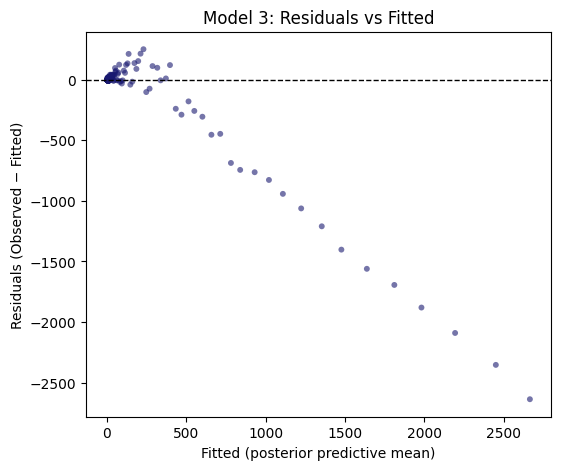


--- Generating Residuals vs. Time Plot (Model 3) ---


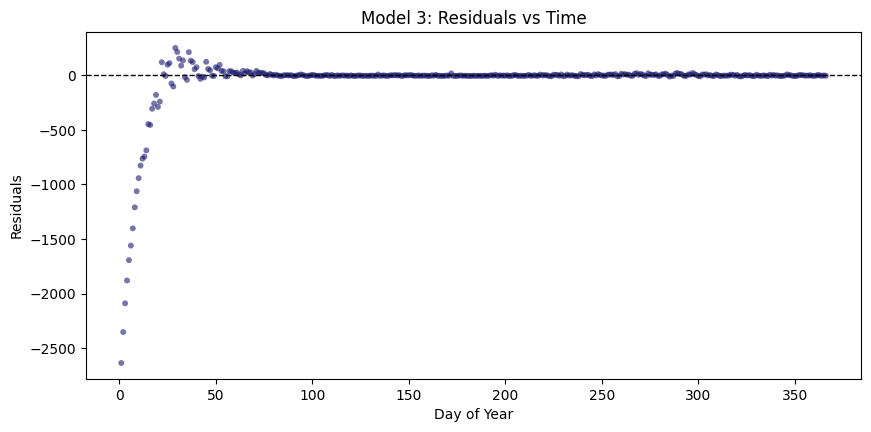

In [11]:
print("\n--- Generating Posterior Predictive Samples for Model 3 ---")
#This gives us a distribution of possible outcomes (posterior predictive)
with model_3_neg_bin:
    ppc_3_neg_bin = pm.sample_posterior_predictive(
        trace_3_neg_bin,
        var_names=["y_obs"]
    )

#Calculate Fitted Values and Residuals
#From the simulated outcomes, take the mean for each day
#This gives us the model’s expected case count (fitted values)
y_pp = ppc_3_neg_bin.posterior_predictive["y_obs"]
y_hat_mean = np.asarray(y_pp.mean(dim=("chain","draw")).values, dtype=float)
fitted = y_hat_mean

#Residuals are the difference between the actual and predicted values
#Large residuals mean the model didn’t predict well for that point
resid = y_data - fitted

#Plot Residuals vs Fitted
#This plot checks if errors are related to the model’s predictions
print("\n--- Generating Residuals vs. Fitted Plot (Model 3) ---")
plt.figure(figsize=(6,5))
plt.scatter(fitted, resid, s=18, alpha=0.6, color="midnightblue", edgecolors="none")
plt.axhline(0, color="k", lw=1, linestyle='--')
plt.title("Model 3: Residuals vs Fitted")
plt.xlabel("Fitted (posterior predictive mean)")
plt.ylabel("Residuals (Observed − Fitted)")
plt.savefig("model_3_resid_vs_fitted.png", dpi=200, bbox_inches="tight")
plt.show()

#Plot Residuals vs Time
#This plot checks if errors are connected to time
print("\n--- Generating Residuals vs. Time Plot (Model 3) ---")
plt.figure(figsize=(10,4.5))
plt.scatter(x_data_orig, resid, s=18, alpha=0.6, color="midnightblue", edgecolors="none")
plt.axhline(0, color="k", lw=1, linestyle='--')
plt.title("Model 3: Residuals vs Time")
plt.xlabel("Day of Year")
plt.ylabel("Residuals")
plt.savefig("model_3_resid_vs_time.png", dpi=200, bbox_inches="tight")
plt.show()


<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3361681214.py:16: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Predicted Mean Cases ($\mu$)')



--- Starting Model 3: Prior Predictive Check ---
Saved 'model_3_prior_check.png'


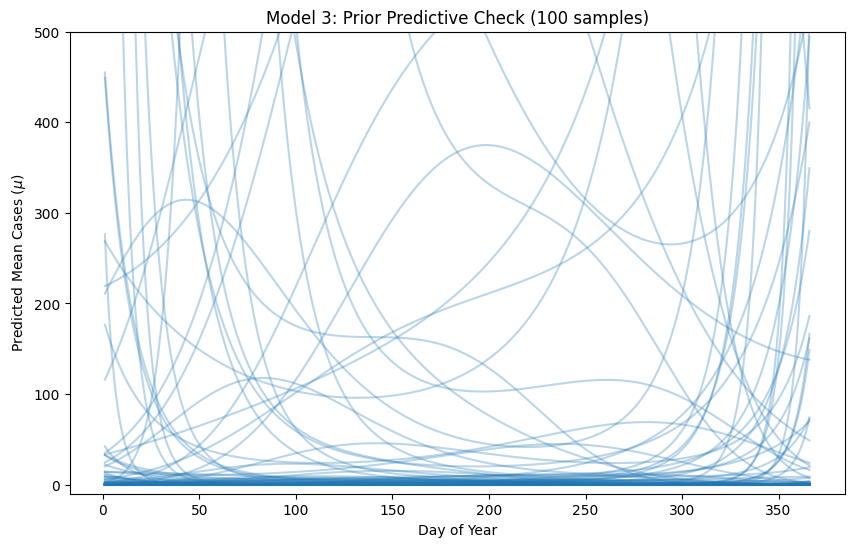

In [12]:
#Model 3: Prior Predictive Check
print("\n--- Starting Model 3: Prior Predictive Check ---")

#This draws predictions from the model using only the prior distributions
#It helps us see if our priors are reasonable before using any actual data
with model_3_neg_bin:
    prior_pred = pm.sample_prior_predictive(samples=100)

#Extract the predicted mean values (mu) from the prior draws
prior_mu_samples = prior_pred.prior["mu"].squeeze()

#Plot the 100 prior predictive lines for μ (mean case count)
plt.figure(figsize=(10, 6))
plt.title('Model 3: Prior Predictive Check (100 samples)')
plt.xlabel('Day of Year')
plt.ylabel('Predicted Mean Cases ($\mu$)')

#loop through and plot each of the 100 prior μ lines
#shows the range and shapes allowed by the priors
for i in range(100):
    plt.plot(x_data_orig, prior_mu_samples[i], 'C0-', alpha=0.3)

#Set y-axis range to keep the plot readable
plt.ylim(-10, 500)
plt.savefig('model_3_prior_check.png')
print("Saved 'model_3_prior_check.png'")
plt.show()

## **Model Comparison**

In [13]:
#FINAL MODEL COMPARISON
print("\n--- Starting Final Model Comparison (PSIS-LOO) ---")

models_dict = {
    "Model 1 (Linear)": trace_1_linear,
    "Model 2 (Cubic-Normal)": trace_2_cubic,
    "Model 3 (Cubic-NegBin)": trace_3_neg_bin
}

compare_df = az.compare(models_dict, ic="loo")
print("\n--- Model Comparison Results ---")
print(compare_df)

compare_df.to_csv("model_comparison_loo.csv")
print("Saved 'model_comparison_loo.csv'")


--- Starting Final Model Comparison (PSIS-LOO) ---

--- Model Comparison Results ---
                        rank     elpd_loo      p_loo   elpd_diff    weight  \
Model 3 (Cubic-NegBin)     0 -1339.912580   5.116531    0.000000  0.987992   
Model 2 (Cubic-Normal)     1 -1975.941850  15.203707  636.029270  0.000000   
Model 1 (Linear)           2 -2074.961866   9.214396  735.049286  0.012008   

                               se        dse  warning scale  
Model 3 (Cubic-NegBin)  31.047582   0.000000    False   log  
Model 2 (Cubic-Normal)  42.083579  37.651564    False   log  
Model 1 (Linear)        36.449112  37.496744    False   log  
Saved 'model_comparison_loo.csv'



--- Model 1: Sampler Diagnostics ---


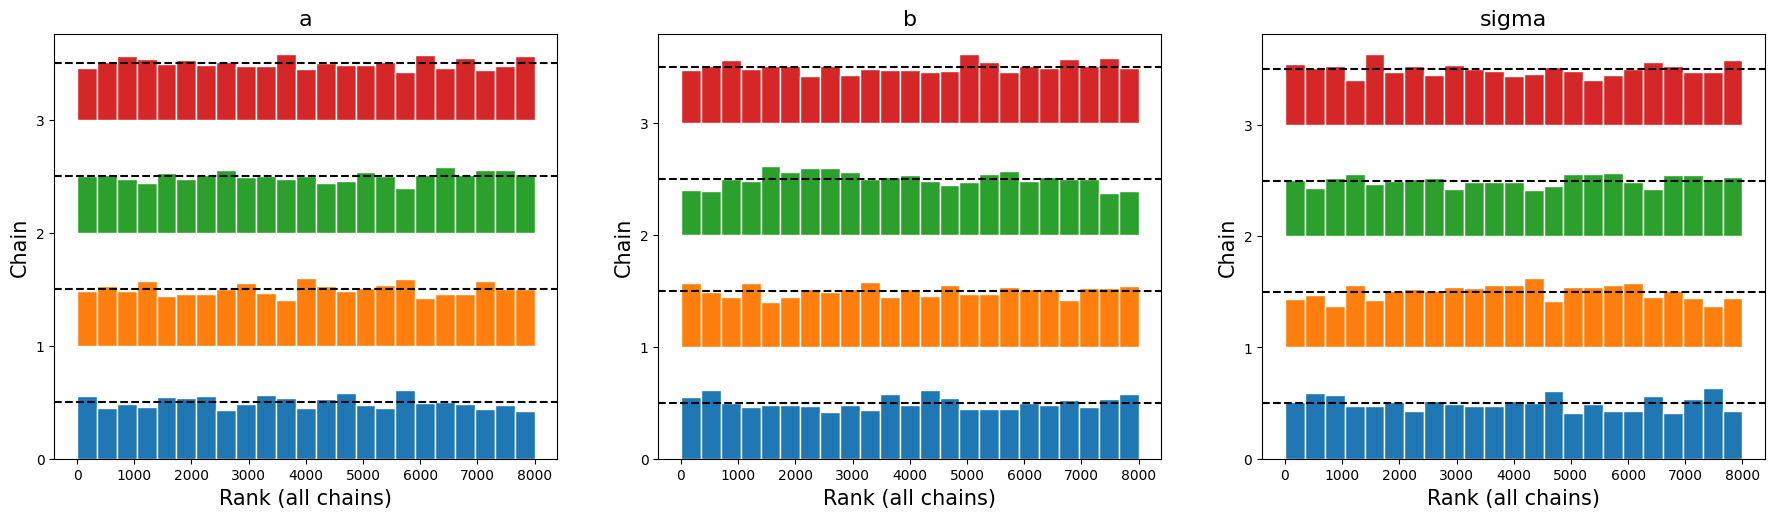


--- Model 2: Sampler Diagnostics ---


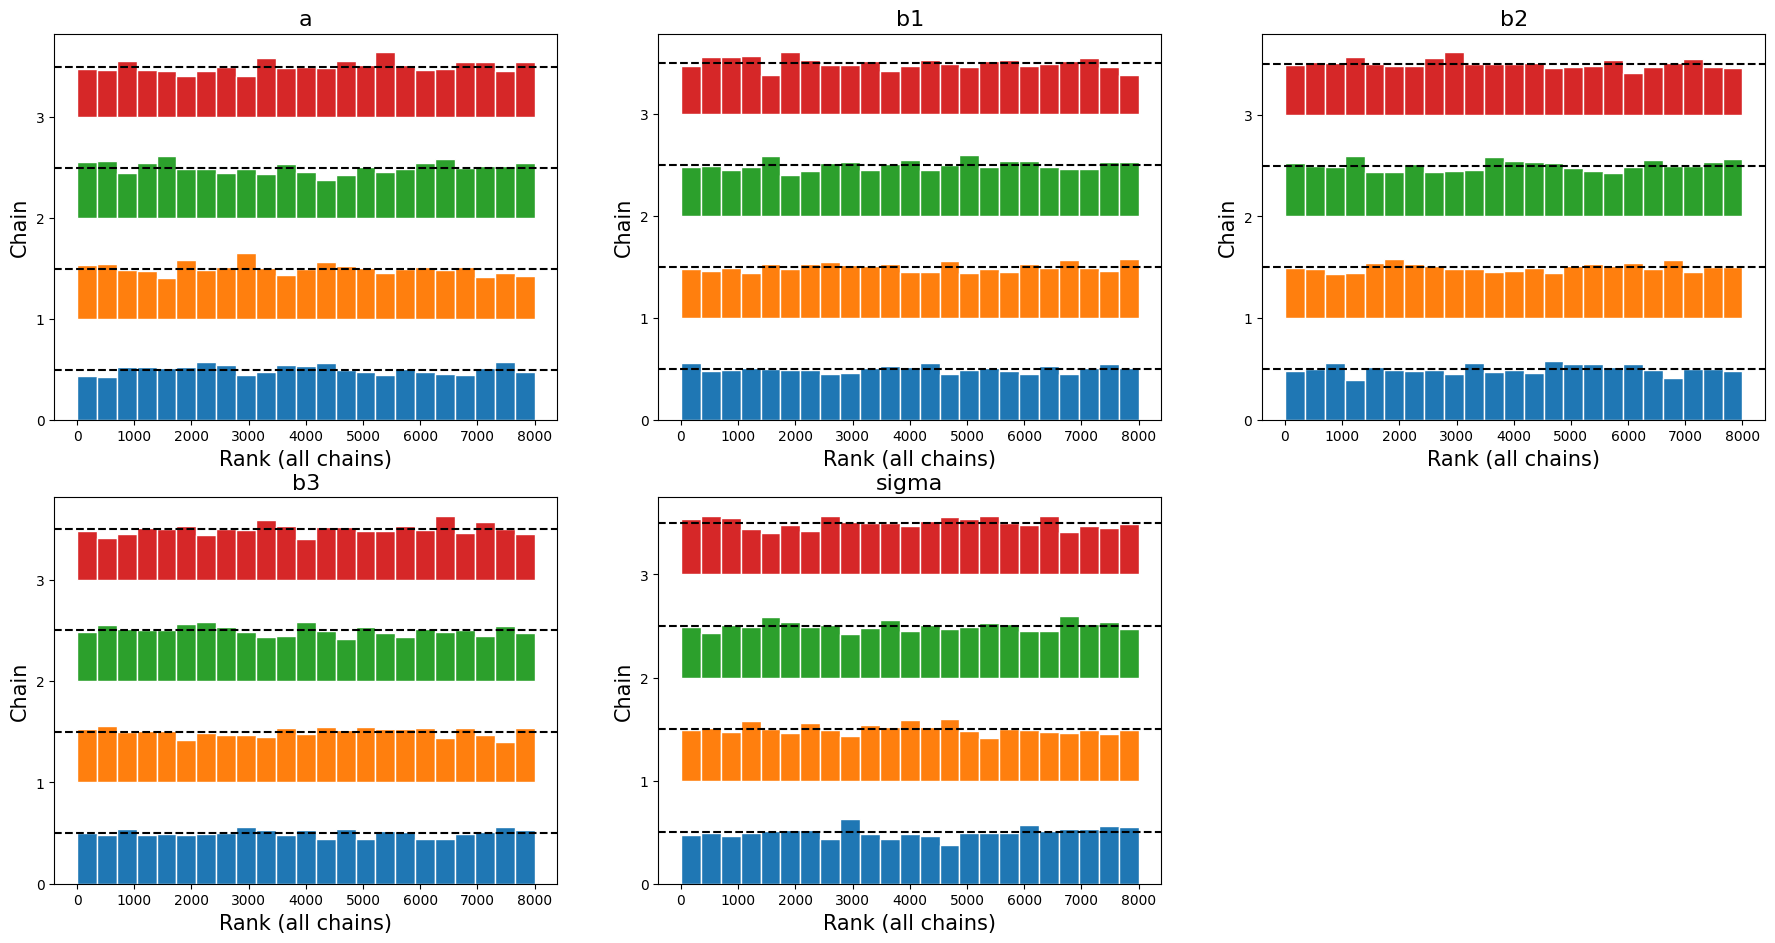


--- Model 3: Sampler Diagnostics ---


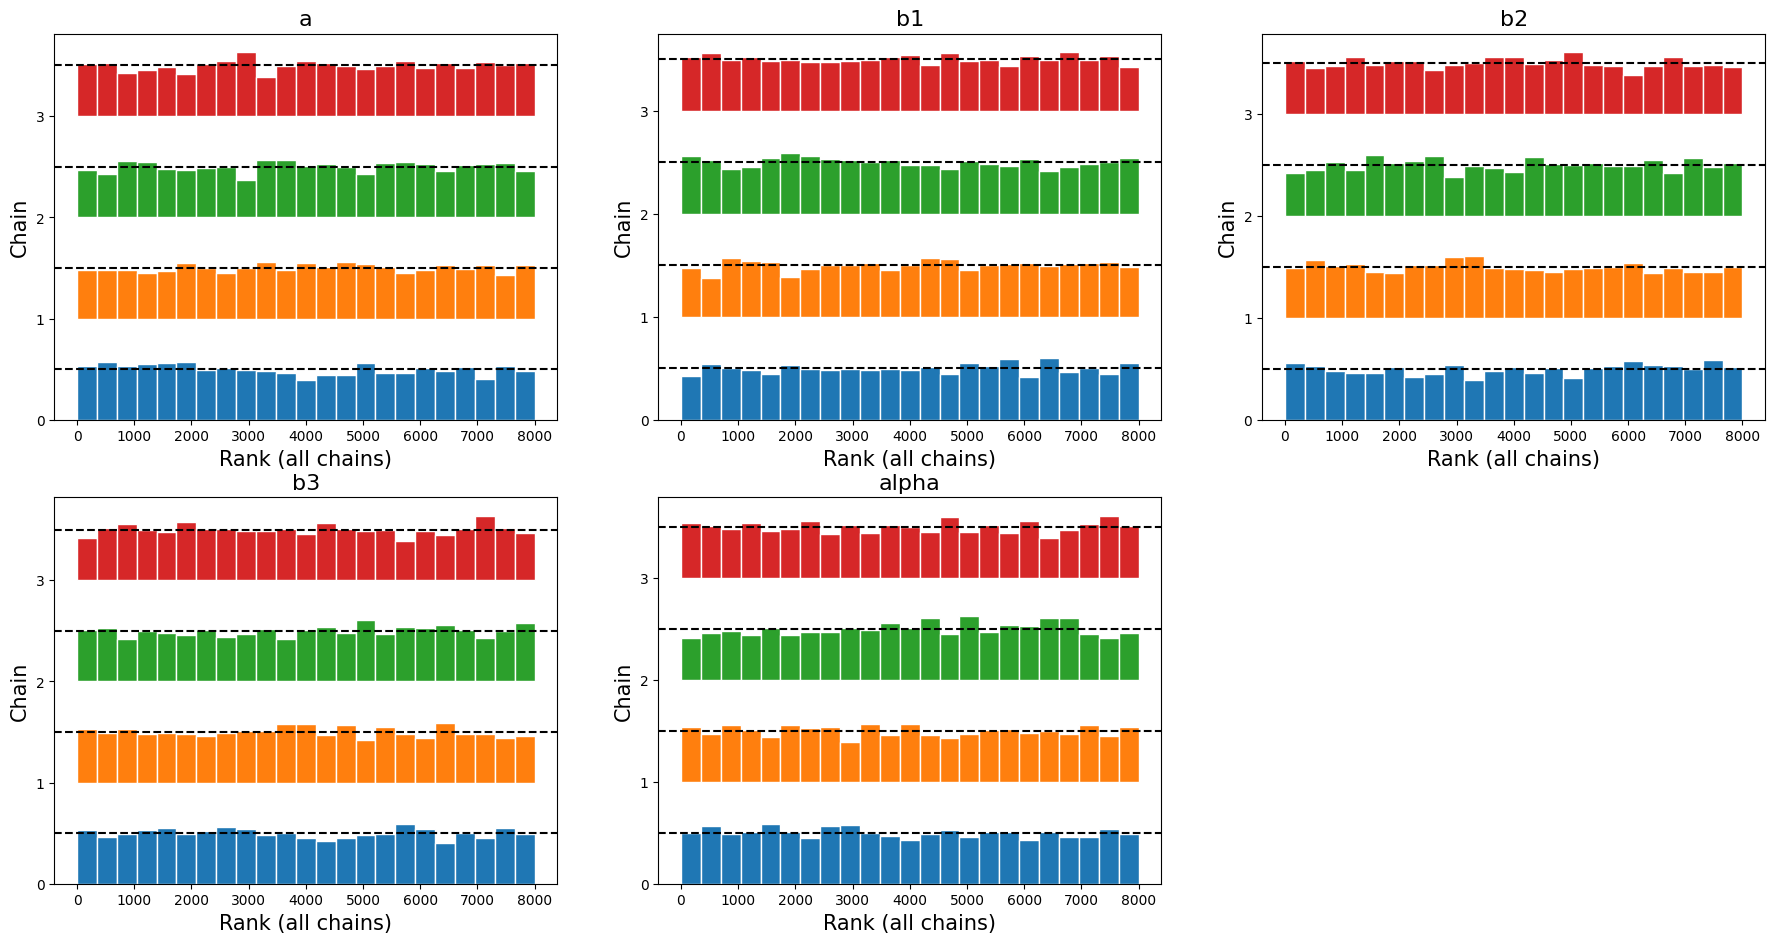

In [14]:
#From session 8 PCW
#Model 1: Sampler Diagnostics (Linear-Normal)
print("\n--- Model 1: Sampler Diagnostics ---")
varnames_1 = ["a", "b", "sigma"]
az.plot_rank(trace_1_linear, var_names=varnames_1)
plt.savefig('model_1_rank_plot.png')
plt.show()

#Model 2: Sampler Diagnostics (Cubic-Normal)
print("\n--- Model 2: Sampler Diagnostics ---")
varnames_2 = ["a", "b1", "b2", "b3", "sigma"]
az.plot_rank(trace_2_cubic, var_names=varnames_2)
plt.savefig('model_2_rank_plot.png')
plt.show()

# Model 3: Sampler Diagnostics (Cubic-NegativeBinomial)
print("\n--- Model 3: Sampler Diagnostics ---")
varnames_3 = ["a", "b1", "b2", "b3", "alpha"]
az.plot_rank(trace_3_neg_bin, var_names=varnames_3)
plt.savefig('model_3_rank_plot.png')
plt.show()

**2. Posterior Interpretation: "What did my model learn?"**

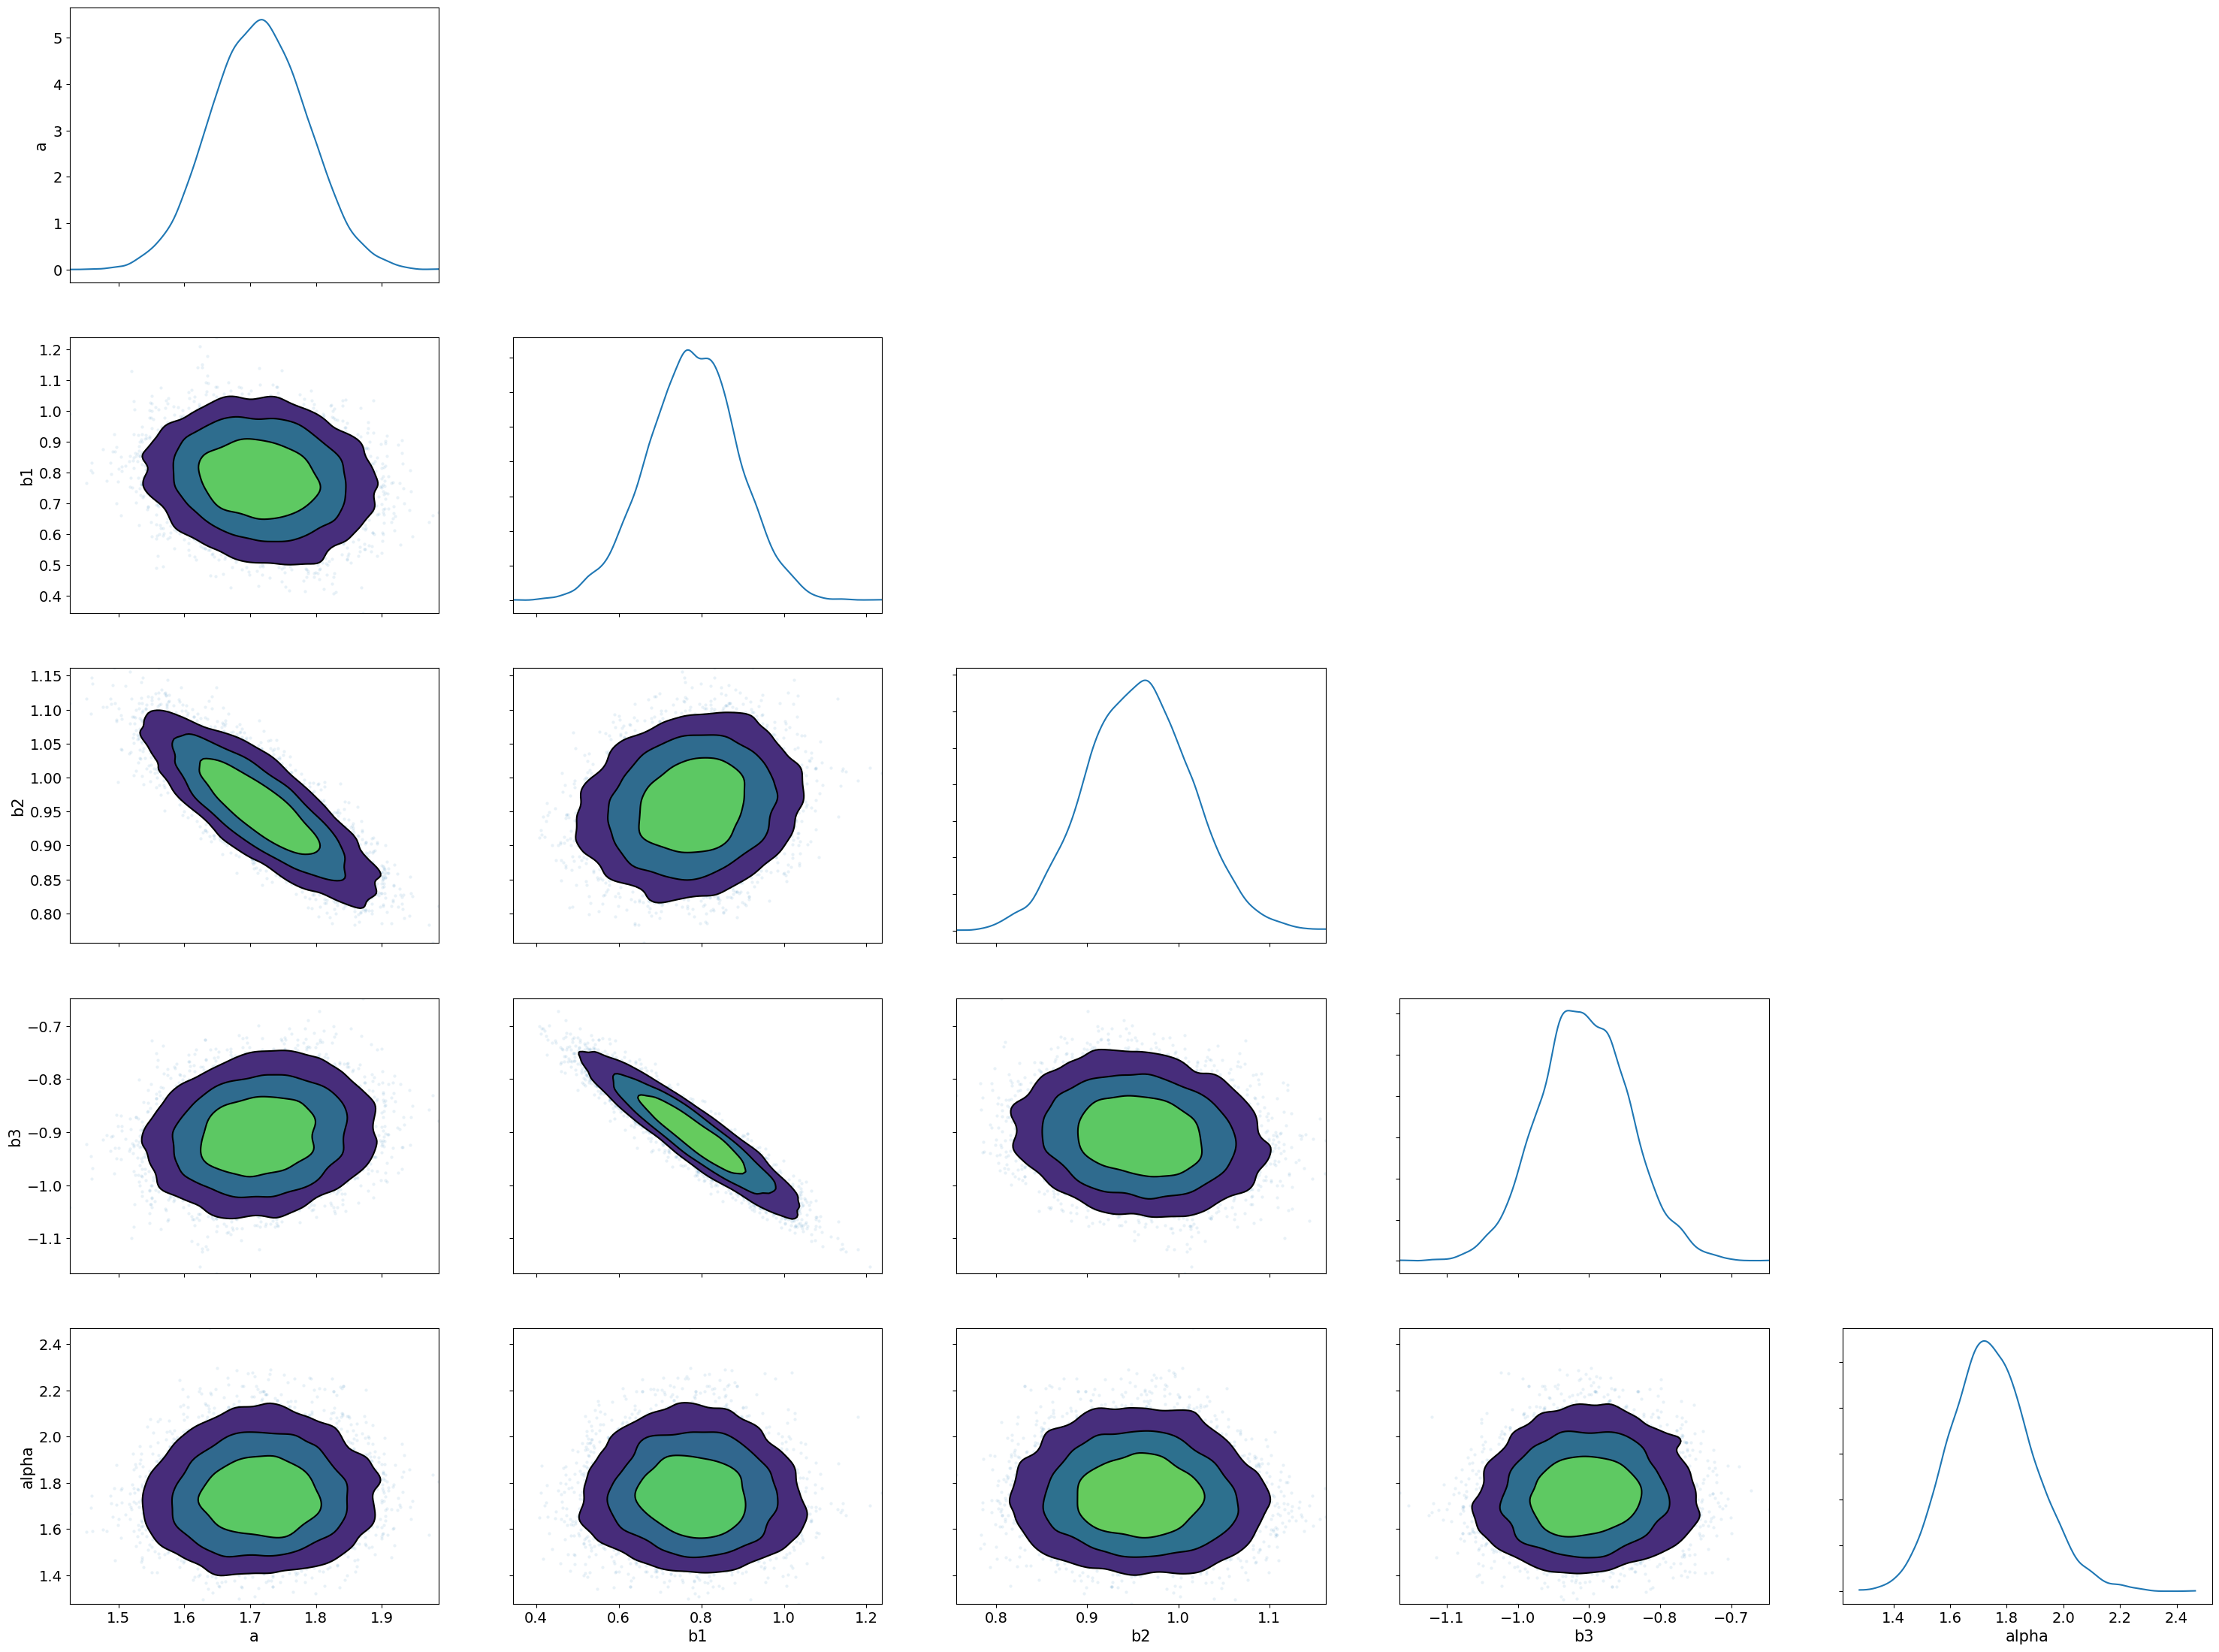

In [15]:
#From session 8 PCW
#Model 3: Pair Plot Diagnostics
# This helps us check for strong correlations or any sampling issues

varnames = ["a", "b1", "b2", "b3", "alpha"]

az.plot_pair(trace_3_neg_bin, var_names=varnames, kind=["scatter", "kde"], marginals=True, scatter_kwargs={"alpha": 0.1})

plt.show()
